# 1 Background 

We all satisfy with those models which dynamically encode (or generate) images. For example in DRAWRNN the model can perform human like digits recognition and generation. And in Attent Inference and Repeat the model can attent to specific part of image and then generate caption according to that part. The common feature among these model is that, a controller neural network controls attention based operations to encode inputs or update hidden states.

However when encoding information from text the most preferential way is still using RNN to sequentially process input tokens one at a time.  Can we develop a architecture such that the model can "learn" its own mechanism to encode text ? 

This project explores the possibility of using the RNN + attention opeartions architecture to develop a more flexible encoder for encoding text.

# 2 Problem 

## 2.1 Avoid Ambiguity

How should the model produces different encoding for "He thinks Bob is good" and "Bob thinks he is good " ?

## 2.2 Varied Length Input 

How should the designed opeartion handles varied length problem ? 

If the model is trained on the sentences with maximum length 30, the model should be able to apply to a sentence whose length is more than 30 without retrain model.

## 2.3 Flexibility (Not for Today Discussion)

Can we expect more flexibility from model ? For example, make the encoding time step and RNN length independent from input length.

( If you are interesting in can find out our draft paper )

# 3 Vanilla Mechanisms

Let's assume we need to calculate $n$ different score for a sentence $\boldsymbol{x}_{1}, ... , \boldsymbol{x}_{n}$ with length $n$. This can be done by following equation: 

\begin{equation}
 \alpha_{i} = Relu(tanh(\boldsymbol{W}\boldsymbol{h}))
\end{equation}

Where $i \in \{1, 2, 3, ..., n\}$, $\boldsymbol{h}$ is hidden state from RNN. When perform reading we simplely do a weighted sum

\begin{equation}
    \boldsymbol{r} = \sum_{i=1}^{n} \alpha_{i}\boldsymbol{E}\boldsymbol{x}_{i}
\end{equation}

This vanilla approach can affective address the issue of ambiguity, since when swap the position of any $\boldsymbol{x}_{i}$ their associate score will also change.

## 3.1 Intermediate Results (Only after 4 epoches training)

|    Encoder   | Decoder |   Embedding Params   | RNN Params | Attention Param | location Params|BLEU |
| ------| :-----:|:----:|:-------------------:| :---------:|:---------------:| :---------------:|:---:|
|  RNN| RNNSearch | 56.8M |  14.9M| 524.8K | -|18.1| 
|  Vanilla | RNNSearch | 56.8M |14.9M| 524.8K |51K| 18.9|

Training are still in progress, both models are still converging

# 3.2 An example of output construction

The results looks reasonable, but this method does not address the issues of varied length input. Can we do better ?

# 4 Location Based Mechanisms (Training In Progressing ...)

In fact each words in a sentence have their own index value 1 to n. We can normalize these index value by the sentence's length $n$ to produce $n$ different positional indicator $p_{i}$. Therefore no matter how long the sentences are their location indicator is also in between 0 and 1. 

Now the neural network can emits a start location indicator $s$ and stop location indicator $e$ and compute the positional score of each words as 
\begin{equation}
 \alpha_{i} = Relu(p_{i} - s ) Relu(e- p_{i})
\end{equation}
or 
\begin{equation}
\alpha_{i} = Relu( 1- |\frac{2}{d}(p_{i} - s) - 1|)
\end{equation}
Where $d = e - s$, we now shortly refer the first method as Relu-product the second as Relu-interval

|    Encoder   | Decoder |   Embedding Params   | RNN Params | Attention Param | location Params|
| ------| :-----:|:----:|:-------------------:| :---------:|:---------------:| :---------------:|
|  RNN| RNNSearch | 56.8M |  14.9M| 524.8K | -|
|  Vanilla | RNNSearch | 56.8M |14.9M| 524.8K |51.2K|
|  Relu-prod | RNNSearch | 56.8M |14.9M| 524.8K |2.0K|
|  Relu-inter | RNNSearch | 56.8M |14.9M| 524.8K |0.5K|




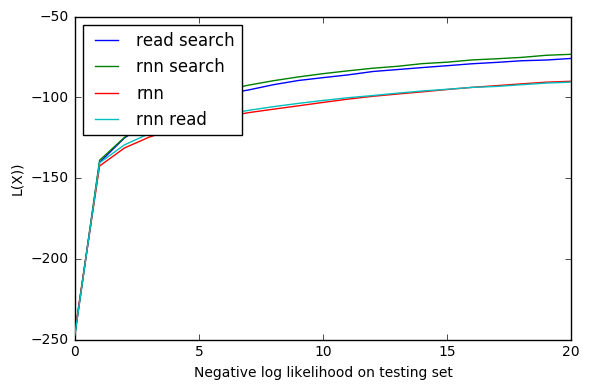

In [17]:
import numpy as np
import matplotlib.pyplot as plt
simple_search_loss = np.load("Translations/show/loss/simple_search_loss.npy")
l = simple_search_loss.shape[0]
search_loss = np.load("Translations/show/loss/search_loss.npy")
seq2seq_loss = np.load("Translations/show/loss/seq2seq_loss.npy")
simple_rnn_loss = np.load("Translations/show/loss/simple_rnn_loss.npy")

plt.plot(-simple_search_loss, label='read search', zorder=0)
plt.plot(-search_loss[:l], label='rnn search', zorder=1)
plt.plot(-seq2seq_loss[:l], label='rnn', zorder=2)
plt.plot(-simple_rnn_loss[:l], label='rnn read', zorder=3)
plt.xlabel('Negative log likelihood on testing set')
plt.ylabel('L(X))')
plt.legend(loc=2)
plt.tight_layout()
plt.show()